<a href="https://colab.research.google.com/github/meiyihTan/sky-segmentation-and-replacement/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [ ]:
import tensorflow as tf # framework
import glob # browse directory 
import os # 
import matplotlib.pyplot as plt # visualization
import cv2 # image processing
import numpy as np
from tqdm import tqdm

## Settings for GPU

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load image paths

In [ ]:
inputs = glob.glob('data/sintl/image/*')
groundtruths = glob.glob('data/sintl/mask/*')

## Load images from path

In [ ]:
#@title Default title text
imgs = [tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128)) for image_path in tqdm(inputs)]
imgs = [tf.keras.preprocessing.image.img_to_array(img, dtype='float32') for img in tqdm(imgs)]
imgs = [img/255.0 for img in tqdm(imgs)]
imgs = np.asarray(imgs) # turn the list into a numpy array
print('input loaded==============')

img1s = [tf.keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=(128, 128)) for mask_path in tqdm(groundtruths)]
img1s = [tf.keras.preprocessing.image.img_to_array(img1, dtype='float32') for img1 in tqdm(img1s)]
img1s = [img/255.0 for img in tqdm(img1s)]
img1s = np.asarray(img1s)
print('masks loaded==============')

  8%|██████▊                                                                         | 35/414 [00:00<00:02, 165.61it/s]

input loaded==============


100%|█████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 29569.04it/s]

masks loaded==============


## Build network

In [ ]:
img_tensor = tf.keras.layers.Input((None, None, 3), name='input')

In [ ]:
n_filters = 16

In [ ]:
def Conv2D_Block(input_tensor, n_filters):
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , kernel_initializer = 'he_normal' , padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
conv1 = Conv2D_Block(img_tensor, n_filters*1)
pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
pool1 = tf.keras.layers.Dropout(0.05)(pool1)

conv2 = Conv2D_Block(pool1, n_filters*2)
pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)
pool2 = tf.keras.layers.Dropout(0.05)(pool2)

conv3 = Conv2D_Block(pool2, n_filters*4)
pool3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)
pool3 = tf.keras.layers.Dropout(0.05)(pool3)

conv4 = Conv2D_Block(pool3, n_filters*8)
pool4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)
pool4 = tf.keras.layers.Dropout(0.05)(pool4)

conv5 = Conv2D_Block(pool4, n_filters*16)

pool6 = tf.keras.layers.Conv2DTranspose(n_filters*8, (3,3), (2,2), padding='same')(conv5)
pool6 = tf.keras.layers.concatenate([pool6 , conv4])
pool6 = tf.keras.layers.Dropout(0.05)(pool6)
conv6 = Conv2D_Block(pool6, n_filters*8)

pool7 = tf.keras.layers.Conv2DTranspose(n_filters*4, (3,3), (2,2), padding='same')(conv6)
pool7 = tf.keras.layers.concatenate([pool7 , conv3])
pool7 = tf.keras.layers.Dropout(0.05)(pool7)
conv7 = Conv2D_Block(pool7, n_filters*4)

pool8 = tf.keras.layers.Conv2DTranspose(n_filters*2, (3,3), (2,2), padding='same')(conv7)
pool8 = tf.keras.layers.concatenate([pool8 , conv2])
pool8 = tf.keras.layers.Dropout(0.05)(pool8)
conv8 = Conv2D_Block(pool8, n_filters*2)

pool9 = tf.keras.layers.Conv2DTranspose(n_filters*1, (3,3), (2,2), padding='same')(conv8)
pool9 = tf.keras.layers.concatenate([pool9, conv1])
pool9 = tf.keras.layers.Dropout(0.05)(pool9)
conv9 = Conv2D_Block(pool9, n_filters*1)

output = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(conv9)

In [ ]:
model = tf.keras.Model(inputs=[img_tensor], outputs=[output], name='Unet')

In [ ]:
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=.9, beta_2=.999, epsilon=1e-08)

In [ ]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 1 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

## Training

In [ ]:
model.fit(x=imgs, y=img1s, epochs=10, batch_size=2)

Epoch 1/10
207/207 [==============================] - 8s 40ms/step - loss: 0.3091 - accuracy: 0.8838
Epoch 2/10
207/207 [==============================] - 8s 40ms/step - loss: 0.2364 - accuracy: 0.9141
Epoch 3/10
207/207 [==============================] - 8s 40ms/step - loss: 0.2182 - accuracy: 0.9251
Epoch 4/10
207/207 [==============================] - 8s 41ms/step - loss: 0.2094 - accuracy: 0.9267
Epoch 5/10
207/207 [==============================] - 9s 41ms/step - loss: 0.2048 - accuracy: 0.9284
Epoch 6/10
207/207 [==============================] - 9s 41ms/step - loss: 0.1946 - accuracy: 0.9305
Epoch 7/10
207/207 [==============================] - 9s 42ms/step - loss: 0.1941 - accuracy: 0.9325
Epoch 8/10
207/207 [==============================] - 9s 42ms/step - loss: 0.1801 - accuracy: 0.9366
Epoch 9/10
207/207 [==============================] - 9s 42ms/step - loss: 0.1869 - accuracy: 0.9310
Epoch 10/10
207/207 [==============================] - 9s 43ms/step - loss: 0.1795 - accura

In [ ]:
model.save_weights('weights.h5')

## Testing the model

In [ ]:
sample = glob.glob('data/sintl/image/*')

In [ ]:
img = tf.keras.preprocessing.image.load_img(sample[28], target_size=(256,256))
img = tf.keras.preprocessing.image.img_to_array(img , dtype='float32')
img = img / 255.0

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
img_tens = tf.expand_dims(img, axis=0)

In [ ]:
img_tens.shape

TensorShape([1, 256, 256, 3])

In [ ]:
res = model.predict(img_tens)

In [ ]:
res.shape

(1, 256, 256, 1)

In [ ]:
im_res = np.squeeze(res, axis=0)

In [ ]:
im_res.shape

(256, 256, 1)

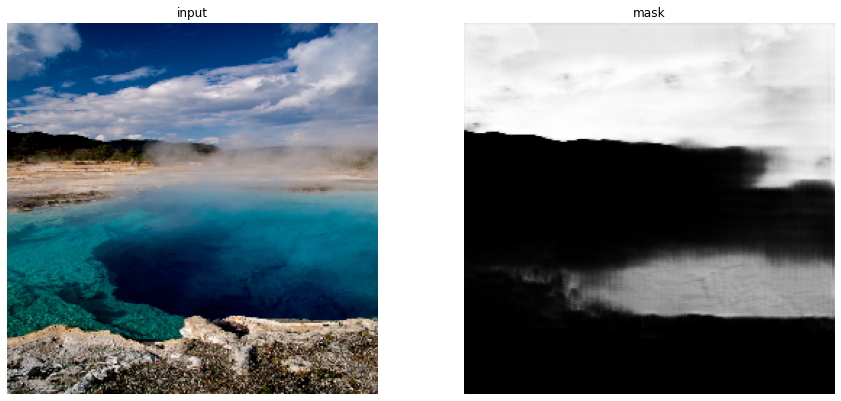

In [ ]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title('input')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(im_res, cmap='gray')
plt.title('mask')
plt.axis('off')

plt.show()